# 목표

keyword가 포함된 N개의 reddit 최신 포스트를 가져와서 문장의 sentiment analiysis를 수행  
keyword에 대한 reddit 유저들의 대략적인 이미지 파악에 도움이 됨  

# 의존성

In [1]:
# !pip install praw pyyaml
# !pip install transformers
# !pip install torch==2.3.0

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# WordCloud 관련
from wordcloud import WordCloud
from PIL import Image
# 텍스트 파싱
import nltk
# 정규표현식 - 특수문자 제거
import re
# WordCloud - 상위 N개 빈출 문자
from collections import Counter
# Python Reddit Api Wrapper
import praw
# For Inject configuration
import yaml
from datetime import datetime

In [3]:
# nltk.download('punkt')
# nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
def reddit_search_api(keyword: str, limit: 10):
    conf = None
    with open('resources/application.yml') as f:
        conf = yaml.safe_load(f)['reddit']


    # Reddit 인스턴스 생성
    reddit = praw.Reddit(
        client_id=conf['client_id'],     # Reddit 앱의 client_id
        client_secret=conf['client_secret'], # Reddit 앱의 client_secret
        user_agent=conf['user_agent'],   # 자신을 식별하는 user_agent
        # username='YOUR_USERNAME',       # (옵션) Reddit 사용자 이름
        # password='YOUR_PASSWORD'        # (옵션) Reddit 비밀번호
    )

    posts = []
    # 인기 서브레딧의 인기 포스트 가져오기
    subreddit = reddit.subreddit('All')
    for post in subreddit.search(keyword, limit=limit):
        posts.append({
            'title': post.title,
            'score': post.score,
            'id': post.id,
            'url': post.url,
            'num_comments': post.num_comments,
            'created': post.created,
            'body': post.selftext
        })
        print(f"제목: {post.title}, 업보트 수: {post.score}, 링크: {post.url}")

    df = pd.DataFrame(posts)
    print(df)
    df.to_json(f'reddit-{keyword}-{str(datetime.now())}.json', force_ascii=False)


In [5]:
keyword = 'Hyundai'
reddit_search_api(keyword, 1000)

제목: Why do Americans hate Hyundai but Australia's like Hyundai?, 업보트 수: 97, 링크: https://www.reddit.com/r/CarsAustralia/comments/1bx1336/why_do_americans_hate_hyundai_but_australias_like/
제목: Why should I NOT buy a Hyundai? , 업보트 수: 120, 링크: https://www.reddit.com/r/whatcarshouldIbuy/comments/1aunvj2/why_should_i_not_buy_a_hyundai/
제목: Why are Hyundais never recommended?, 업보트 수: 140, 링크: https://www.reddit.com/r/whatcarshouldIbuy/comments/15z12vp/why_are_hyundais_never_recommended/
제목: What happened to Hyundai/Kia?, 업보트 수: 0, 링크: https://www.reddit.com/r/cars/comments/18t7k2z/what_happened_to_hyundaikia/
제목: Are Kia & Hyundai still bad brands?, 업보트 수: 55, 링크: https://www.reddit.com/r/whatcarshouldIbuy/comments/1auh1e5/are_kia_hyundai_still_bad_brands/
제목: Why do you think people buy Hyundai/Kia's ?, 업보트 수: 383, 링크: https://www.reddit.com/r/whatcarshouldIbuy/comments/17c1bsu/why_do_you_think_people_buy_hyundaikias/
제목: Are Kia and Hyundai really that bad?+, 업보트 수: 171, 링크: https://www.re

In [6]:
import glob
import os

# path에서 패턴에 매칭되는 파일을 판다스로 읽어서 병합 후 반환
def read_reddit_json_files(directory_path, keyword):
    # 파일 패턴 정의
    file_pattern = os.path.join(directory_path, f'reddit-{keyword}-*.json')
    
    # 패턴에 맞는 파일 목록 찾기
    json_files = glob.glob(file_pattern)
    
    # JSON 파일이 있는지 확인
    if not json_files:
        print(f"No files found for keyword '{keyword}' in directory '{directory_path}'.")
        return None
    
    # 파일을 읽어 데이터프레임으로 변환
    dfs = []
    for file in json_files:
        try:
            df = pd.read_json(file)
            dfs.append(df)
        except ValueError as e:
            print(f"Error reading {file}: {e}")
    
    # 데이터프레임을 하나로 병합
    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
        return combined_df
    else:
        print("No valid JSON files found.")
        return None


In [7]:
# 예시 사용
directory_path = ''  # JSON 파일들이 있는 디렉터리 경로
df = read_reddit_json_files(directory_path, keyword)

if df is not None:
    print(df.head(2))

                                               title  score       id  \
0  Why do Americans hate Hyundai but Australia's ...     98  1bx1336   
1                   Why should I NOT buy a Hyundai?     120  1aunvj2   

                                                 url  num_comments  \
0  https://www.reddit.com/r/CarsAustralia/comment...           252   
1  https://www.reddit.com/r/whatcarshouldIbuy/com...           264   

      created                                               body  
0  1712372553  Just curious- \n\nAfter doing travelling I not...  
1  1708351006                                     Do your worst   


In [8]:
df['text'] = df['title'] + df['body']

In [9]:
# 허깅페이스, sentiment-analysis 모델 사용
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
# 감정 분석 수행 함수 정의
def analyze_sentiment(text):
    result = sentiment_pipeline(text)[0]
    return result['label'], result['score']

# 새로운 컬럼으로 추가, 각 텍스트 길이는 최대 512자.
df[['sentiment', 'confidence']] = df['text'].apply(lambda x: pd.Series(analyze_sentiment(x[:512])))

df

/Users/admin/data-engineering-course/missions/W2/sentiment-analysis/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


,title,score,id,url,num_comments,created,body,text,sentiment,confidence
0,Why do Americans hate Hyundai but Australia's ...,98,1bx1336,https://www.reddit.com/r/CarsAustralia/comment...,252,1712372553,Just curious- \n\nAfter doing travelling I not...,Why do Americans hate Hyundai but Australia's ...,POSITIVE,0.991165
1,Why should I NOT buy a Hyundai?,120,1aunvj2,https://www.reddit.com/r/whatcarshouldIbuy/com...,264,1708351006,Do your worst,Why should I NOT buy a Hyundai? Do your worst,NEGATIVE,0.999687
2,Why are Hyundais never recommended?,142,15z12vp,https://www.reddit.com/r/whatcarshouldIbuy/com...,448,1692789984,Besides the fuck up with the immobilizer and c...,Why are Hyundais never recommended?Besides the...,NEGATIVE,0.992455
3,What happened to Hyundai/Kia?,0,18t7k2z,https://www.reddit.com/r/cars/comments/18t7k2z...,151,1703805130,Pre-2015 Hyundai/Kia had a reputation of being...,What happened to Hyundai/Kia?Pre-2015 Hyundai/...,NEGATIVE,0.997392
4,Are Kia & Hyundai still bad brands?,56,1auh1e5,https://www.reddit.com/r/whatcarshouldIbuy/com...,101,1708325751,I came across a couple posts recently that con...,Are Kia & Hyundai still bad brands?I came acro...,NEGATIVE,0.996423
...,...,...,...,...,...,...,...,...,...,...
473,Hyundai subsidiary used child labor at Alabama...,1195,w5b7af,https://www.reuters.com/world/us/exclusive-hyu...,201,1658498016,,Hyundai subsidiary used child labor at Alabama...,NEGATIVE,0.994401
474,"Hyundai Pony EV, Grandeur EV, N Vision 74(Conc...",2510,w0fc0c,https://www.reddit.com/gallery/w0fc0c,147,1657973754,,"Hyundai Pony EV, Grandeur EV, N Vision 74(Conc...",POSITIVE,0.995716
475,Hyundai boss admits surprise at success of Ion...,726,127dc5i,https://www.autocar.co.uk/car-news/new-cars/hy...,272,1680246802,,Hyundai boss admits surprise at success of Ion...,POSITIVE,0.991310
476,Genesis' New Standalone Dealerships Leave Hyun...,1239,12z6zd4,https://www.motortrend.com/reviews/2022-genesi...,222,1682485191,,Genesis' New Standalone Dealerships Leave Hyun...,NEGATIVE,0.999567


In [10]:
def remove_special_symbol(text): # 특수문자 제거
    return re.sub(r'[^A-Za-z0-9\s]', '', text)

In [11]:
positive = df[df['sentiment']=='POSITIVE']
negative = df[df['sentiment']=='NEGATIVE']

In [12]:
# 하나의 큰 문자열로 변환
positive_texts = ' '.join(positive['text'])
negative_texts = ' '.join(negative['text'])

In [13]:
# 특수문자 제거
positive_symbol_removed_texts = remove_special_symbol(positive_texts)
negative_symbol_removed_texts = remove_special_symbol(negative_texts)

In [14]:
# 토크나이즈
positive_tokens = nltk.word_tokenize(positive_symbol_removed_texts)
negative_tokens = nltk.word_tokenize(negative_symbol_removed_texts)

In [15]:
stopwords = nltk.corpus.stopwords.words('english') # 영어 불용어 세트(소문자)

In [16]:
# 불용어 제거
positive_stopwords_removed_tokens = [t.lower() for t in positive_tokens if t.lower() not in stopwords]
negative_stopwords_removed_tokens = [t.lower() for t in negative_tokens if t.lower() not in stopwords]

In [17]:
# 카운터 생성( 단어 : 빈도수 )
positive_count_set = Counter(positive_stopwords_removed_tokens)
negative_count_set = Counter(negative_stopwords_removed_tokens)

In [18]:
N = 500 # 상위 50개 항목만 도출
topN_positive_tokens = positive_count_set.most_common(N)
topN_negative_tokens = negative_count_set.most_common(N)

topN_positive_tokens_dict = dict(topN_positive_tokens)
topN_negative_tokens_dict = dict(topN_negative_tokens)

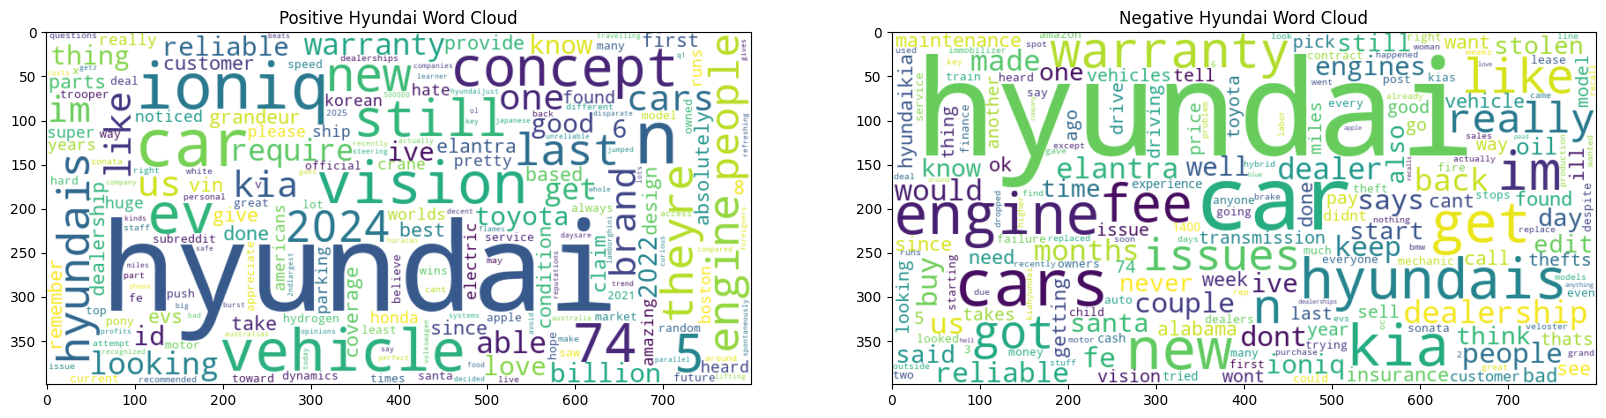

In [19]:
# 워드클라우드 생성
wc1 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topN_positive_tokens_dict)
wc2 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topN_negative_tokens_dict)

# 워드클라우드 시각화
plt.figure(figsize=(20, 10))

# 첫 번째 워드클라우드
plt.subplot(1, 2, 1)
plt.imshow(wc1, interpolation='bilinear')
# plt.axis('off')
plt.title(f'Positive {keyword} Word Cloud')

# 두 번째 워드클라우드
plt.subplot(1, 2, 2)
plt.imshow(wc2, interpolation='bilinear')
# plt.axis('off')
plt.title(f'Negative {keyword} Word Cloud')

plt.show()

In [ ]:
from flask import Flask, request, jsonify
import pandas as pd
import matplotlib.pyplot as plt

app = Flask(__name__)

def analyze_keyword(keyword):
    reddit_search_api(keyword, 1000)
    directory_path = ''  # JSON 파일들이 있는 디렉터리 경로
    df = read_reddit_json_files(directory_path, keyword)
    df['text'] = df['title'] + df['body']
    df[['sentiment', 'confidence']] = df['text'].apply(lambda x: pd.Series(analyze_sentiment(x[:512])))

    positive = df[df['sentiment']=='POSITIVE']
    negative = df[df['sentiment']=='NEGATIVE']


    # 하나의 큰 문자열로 변환
    positive_texts = ' '.join(positive['text'])
    negative_texts = ' '.join(negative['text'])

    # 특수문자 제거
    positive_symbol_removed_texts = remove_special_symbol(positive_texts)
    negative_symbol_removed_texts = remove_special_symbol(negative_texts)

    # 토크나이즈
    positive_tokens = nltk.word_tokenize(positive_symbol_removed_texts)
    negative_tokens = nltk.word_tokenize(negative_symbol_removed_texts)


    stopwords = nltk.corpus.stopwords.words('english') # 영어 불용어 세트(소문자)

    # 불용어 제거
    positive_stopwords_removed_tokens = [t.lower() for t in positive_tokens if t.lower() not in stopwords]
    negative_stopwords_removed_tokens = [t.lower() for t in negative_tokens if t.lower() not in stopwords]

    # 카운터 생성( 단어 : 빈도수 )
    positive_count_set = Counter(positive_stopwords_removed_tokens)
    negative_count_set = Counter(negative_stopwords_removed_tokens)

    N = 500 # 상위 50개 항목만 도출
    topN_positive_tokens = positive_count_set.most_common(N)
    topN_negative_tokens = negative_count_set.most_common(N)

    topN_positive_tokens_dict = dict(topN_positive_tokens)
    topN_negative_tokens_dict = dict(topN_negative_tokens)

    return {'positive' : topN_positive_tokens_dict, 'negative' : topN_negative_tokens_dict }

@app.route('/analyze', methods=['POST'])
def analyze():
    keyword = request.json.get('keyword')
    if keyword:
        data = analyze_keyword(keyword)
        return jsonify(data)
    else:
        return jsonify({"error": "No keyword provided"}), 400

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5001)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5001
 * Running on http://10.6.13.145:5001
Press CTRL+C to quit


제목: Why do Americans hate Hyundai but Australia's like Hyundai?, 업보트 수: 100, 링크: https://www.reddit.com/r/CarsAustralia/comments/1bx1336/why_do_americans_hate_hyundai_but_australias_like/
제목: Why should I NOT buy a Hyundai? , 업보트 수: 119, 링크: https://www.reddit.com/r/whatcarshouldIbuy/comments/1aunvj2/why_should_i_not_buy_a_hyundai/
제목: Why are Hyundais never recommended?, 업보트 수: 141, 링크: https://www.reddit.com/r/whatcarshouldIbuy/comments/15z12vp/why_are_hyundais_never_recommended/
제목: What happened to Hyundai/Kia?, 업보트 수: 0, 링크: https://www.reddit.com/r/cars/comments/18t7k2z/what_happened_to_hyundaikia/
제목: Are Kia & Hyundai still bad brands?, 업보트 수: 55, 링크: https://www.reddit.com/r/whatcarshouldIbuy/comments/1auh1e5/are_kia_hyundai_still_bad_brands/
제목: Why do you think people buy Hyundai/Kia's ?, 업보트 수: 385, 링크: https://www.reddit.com/r/whatcarshouldIbuy/comments/17c1bsu/why_do_you_think_people_buy_hyundaikias/
제목: Are Kia and Hyundai really that bad?+, 업보트 수: 172, 링크: https://www.r

127.0.0.1 - - [10/Jul/2024 18:19:28] "POST /analyze HTTP/1.1" 200 -


제목: Digging holes for Trees , 업보트 수: 15201, 링크: https://v.redd.it/02cdljfj368d1
제목: Harvesting Latex From Trees, 업보트 수: 14944, 링크: https://v.redd.it/2u887mb0ll3d1
제목: Stop Planting Trees, Says Guy Who Inspired World to Plant a Trillion Trees, 업보트 수: 227, 링크: https://www.wired.com/story/stop-planting-trees-thomas-crowther/
제목: Why is /r/trees named that?, 업보트 수: 1875, 링크: https://www.reddit.com/r/OutOfTheLoop/comments/3igq90/why_is_rtrees_named_that/
제목: Lots of trees, 업보트 수: 270, 링크: https://www.reddit.com/gallery/17au3ht
제목: Trees, 업보트 수: 3, 링크: https://www.reddit.com/r/EverAfterFalls/comments/1dps7gs/trees/
제목: Trees surrounding house. Could I make Starlink work?, 업보트 수: 10, 링크: https://www.reddit.com/gallery/170pd2w
제목: Best tree mod?, 업보트 수: 19, 링크: https://www.reddit.com/r/SkyrimModsXbox/comments/16m96qm/best_tree_mod/
제목: clipping the palm trees, 업보트 수: 17867, 링크: https://v.redd.it/kxk4w4otm7jc1
제목: Tricker trees, 업보트 수: 54944, 링크: https://www.reddit.com/gallery/17j1bhv
제목: New J

127.0.0.1 - - [10/Jul/2024 18:30:54] "POST /analyze HTTP/1.1" 200 -


제목: Apple Bill, 업보트 수: 201, 링크: https://www.reddit.com/r/hungary/comments/1dqcf43/apple_bill/
제목: Apple Juice , 업보트 수: 17418, 링크: https://v.redd.it/22oijaoqgtyc1
제목: Apple Pay kálvária, tapasztalatok?, 업보트 수: 134, 링크: https://i.redd.it/uv7hpbrziz8d1.jpeg
제목: "Apple" Discussion Megathread, 업보트 수: 13, 링크: https://www.reddit.com/r/charlixcx/comments/1d9k3th/apple_discussion_megathread/
제목: Apple korai előfizetés kiszámlázás, 업보트 수: 21, 링크: https://www.reddit.com/r/hungary/comments/1dp5yv9/apple_korai_előfizetés_kiszámlázás/
제목: Is Apple really that bad?, 업보트 수: 114, 링크: https://www.reddit.com/r/privacy/comments/14wdlvy/is_apple_really_that_bad/
제목: Apple is falling so far behind, 업보트 수: 279, 링크: https://www.reddit.com/r/singularity/comments/1asfii1/apple_is_falling_so_far_behind/
제목: Megbolondult az Apple Pay, tömegesen von le pénzt a használóktól, 업보트 수: 105, 링크: https://telex.hu/gazdasag/2024/06/26/apple-pay-levonas-fizetes-otp-bank
제목: What’s everyone’s thoughts on the Apple CC?, 업보트 수

127.0.0.1 - - [10/Jul/2024 18:32:24] "POST /analyze HTTP/1.1" 200 -
